In [4]:
# Подключаем kaggle.json
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')
files.upload()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"egorkeen2","key":"93fa279ba640a1df760d59dbdb9b50aa"}'}

In [5]:
# Проверяем наличие kaggle
!ls -lha kaggle.json

# устанавливаем API Client
!pip install -q kaggle

# Создаем папку ./kaggle, перемещаем туда kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# даём необходимые права
!chmod 600 /root/.kaggle/kaggle.json

# Скачиваем и распаковываем датасет
!kaggle datasets download -d whenamancodes/predict-diabities
!unzip predict-diabities.zip

-rw-r--r-- 1 root root 65 Dec 19 16:19 kaggle.json
predict-diabities.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  predict-diabities.zip
replace diabetes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: diabetes.csv            


In [6]:
# Уберем предупреждения, чтобы они не загромождали вывод
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Установим размеры шрифтов для графиков
import matplotlib.pyplot as plt

plt.rc('font', size=16)          # размеры текста по умолчанию
plt.rc('axes', titlesize=20)     # размер шрифта заголовка осей
plt.rc('axes', labelsize=18)     # размер шрифта названия осей
plt.rc('xtick', labelsize=18)    # размер шрифта меток по оси x
plt.rc('ytick', labelsize=18)    # размер шрифта меток по оси y
plt.rc('legend', fontsize=16)    # размер шрифта легенды
plt.rc('figure', titlesize=20)   # размер шрифта заголовка всего графика

In [8]:
# Разведочный анализ и предобработка данных

import pandas as pd

df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
target = df["Outcome"]

df = df.drop("Outcome", axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [10]:
numerical_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols) == df.shape[1]

True

In [11]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [12]:
# Деление выборки на обучающую и тестовую

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    target,
    test_size=0.33,
    random_state=42,
    stratify=target,
)
X_train.shape, X_test.shape

((514, 8), (254, 8))

In [13]:
# Смотрим на баланс классов

val_count_init = pd.Series(target).value_counts().to_dict()
val_count_train = y_train.value_counts().to_dict()
val_count_test = y_test.value_counts().to_dict()

get_relation = lambda x: round(x[1] / x[0], 2)

print(
    """
    Соотношение классов в исходной выборке:  {}\t(класс 1 / класс 0 = {})
    Соотношение классов в обучающей выборке: {}\t(класс 1 / класс 0 = {})
    Соотношение классов в тестовой выборке:  {}\t(класс 1 / класс 0 = {})
    """.format(
        val_count_init, get_relation(val_count_init),
        val_count_train, get_relation(val_count_train),
        val_count_test, get_relation(val_count_test),
    )
)


    Соотношение классов в исходной выборке:  {0: 500, 1: 268}	(класс 1 / класс 0 = 0.54)
    Соотношение классов в обучающей выборке: {0: 335, 1: 179}	(класс 1 / класс 0 = 0.53)
    Соотношение классов в тестовой выборке:  {0: 165, 1: 89}	(класс 1 / класс 0 = 0.54)
    


In [14]:
# Достаем F1-меру и PR AUC

from sklearn.metrics import (
    f1_score,
    average_precision_score,
)

In [15]:
# Функция для вычисления и выведения F1-меры и PR AUC

import numpy as np

def get_all_metrics(
    true_labels,
    predictions,
    probabilities,
    print_metrics=False,
):
    """Подсчёт и вывод всех метрик.

    :param true_labels: истинные метки классов
    :param predictions: предсказания (метки классов)
    :param probabilities: предсказания (вероятности принадлежности каждого объекта к каждому классу)
    :param print_metrics: если True, то печатает получившиеся метрики
    :return: словарь, ключи которого -- названия метрик, значения -- получившиеся метрики
    """
    f1 = f1_score(true_labels, predictions)
    pr_auc =  average_precision_score(true_labels, probabilities)

    if print_metrics:
        print(
            "F1-мера = {}\nPR AUC = {}".format(
                round(f1, 3), round(pr_auc, 3)
            )
        )
    return {
        "F1-score": f1,
        "PR AUC": pr_auc,
    }

In [16]:
# Выбор, обучение и тестирование моделей

from xgboost import XGBClassifier                   # градиентный бустинг
from sklearn.ensemble import (
    AdaBoostClassifier,                             # адаптивный бустинг
    RandomForestClassifier,                         # бэггинг
    StackingClassifier,                             # стекинг
    VotingClassifier,                               # вотинг
)

from sklearn.tree import DecisionTreeClassifier

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# Функция для обучения, тестирования модели и вычисления метрик качества

import matplotlib.pyplot as plt

def model_train_test(X_train, y_train, X_test, y_test, model):
    """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

    :param X_train: объекты обучающей выборки
    :param y_train: значения целевой переменной обучающей выборки
    :param X_test: объекты тестовой выборки
    :param y_test: значения целевой переменной тестовой выборки
    :param model: модель, которая обучается и тестируется
    :return: предсказания -- классы и вероятности принадлежности к каждому классу, все метрики
    """
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)

    print(str(model), end="\n\n")

    all_metrics = get_all_metrics(
        y_test,
        pred,
        proba[:, 1],
        print_metrics=True,
    )
    return model, pred, proba, all_metrics

In [19]:
# Сравнение алгоритмов со стандартными гиперпараметрами

model_logreg, pred_logreg, proba_logreg, all_metrics_logreg = model_train_test(
    X_train, y_train,
    X_test, y_test,
    LogisticRegression(),
)

LogisticRegression()

F1-мера = 0.596
PR AUC = 0.727


In [20]:
model_xgb, pred_xgb, proba_xgb, all_metrics_xgb = model_train_test(
    X_train, y_train,
    X_test, y_test,
    XGBClassifier(),
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

F1-мера = 0.582
PR AUC = 0.643


In [21]:
model_adab, pred_adab, proba_adab, all_metrics_adab = model_train_test(
    X_train, y_train,
    X_test, y_test,
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier()
    ),
)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

F1-мера = 0.535
PR AUC = 0.456


In [22]:
model_rf, pred_rf, proba_rf, all_metrics_rf = model_train_test(
    X_train, y_train,
    X_test, y_test,
    RandomForestClassifier(),
)

RandomForestClassifier()

F1-мера = 0.601
PR AUC = 0.691


In [23]:
model_trees_stacking, pred_trees_stacking, proba_trees_stacking, all_metrics_trees_stacking = model_train_test(
    X_train, y_train,
    X_test, y_test,
    StackingClassifier(
        estimators=[
            ("decision_tree_{}".format(i+1), DecisionTreeClassifier()) for i in range(10)
        ],
        final_estimator=DecisionTreeClassifier()
    ),
)

StackingClassifier(estimators=[('decision_tree_1', DecisionTreeClassifier()),
                               ('decision_tree_2', DecisionTreeClassifier()),
                               ('decision_tree_3', DecisionTreeClassifier()),
                               ('decision_tree_4', DecisionTreeClassifier()),
                               ('decision_tree_5', DecisionTreeClassifier()),
                               ('decision_tree_6', DecisionTreeClassifier()),
                               ('decision_tree_7', DecisionTreeClassifier()),
                               ('decision_tree_8', DecisionTreeClassifier()),
                               ('decision_tree_9', DecisionTreeClassifier()),
                               ('decision_tree_10', DecisionTreeClassifier())],
                   final_estimator=DecisionTreeClassifier())

F1-мера = 0.515
PR AUC = 0.438


In [24]:
model_trees_voting, pred_trees_voting, proba_trees_voting, all_metrics_trees_voting = model_train_test(
    X_train, y_train,
    X_test, y_test,
    VotingClassifier(
        estimators=[
            ("decision_tree_{}".format(i+1), DecisionTreeClassifier()) for i in range(10)
        ],
        voting="soft"
    ),
)

VotingClassifier(estimators=[('decision_tree_1', DecisionTreeClassifier()),
                             ('decision_tree_2', DecisionTreeClassifier()),
                             ('decision_tree_3', DecisionTreeClassifier()),
                             ('decision_tree_4', DecisionTreeClassifier()),
                             ('decision_tree_5', DecisionTreeClassifier()),
                             ('decision_tree_6', DecisionTreeClassifier()),
                             ('decision_tree_7', DecisionTreeClassifier()),
                             ('decision_tree_8', DecisionTreeClassifier()),
                             ('decision_tree_9', DecisionTreeClassifier()),
                             ('decision_tree_10', DecisionTreeClassifier())],
                 voting='soft')

F1-мера = 0.512
PR AUC = 0.501


In [26]:
# Обобщим результаты

metrics_df = pd.DataFrame(
    [all_metrics_logreg, all_metrics_adab, all_metrics_xgb, all_metrics_rf, all_metrics_trees_stacking, all_metrics_trees_voting],
    index=["Logistic Regression", "AdaBoost", "XGBoost", "RandomForest", "Stacking", "Voting"]
)
metrics_df.sort_values(by=["F1-score", "PR AUC"], ascending=False)

,F1-score,PR AUC
RandomForest,0.601227,0.690882
Logistic Regression,0.596273,0.726955
XGBoost,0.581818,0.643441
AdaBoost,0.534884,0.455741
Stacking,0.514970,0.437798
Voting,0.512500,0.500786


In [29]:
# рассмотрение важности признаков

logreg_coefs = np.abs(model_logreg.coef_).squeeze()

print(
    "Наиболее важный признак: {}\nНаименее важный признак: {}".format(
        X_train.columns[np.argmax(logreg_coefs)],
        X_train.columns[np.argmin(logreg_coefs)]
    )
)

Наиболее важный признак: DiabetesPedigreeFunction
Наименее важный признак: Insulin


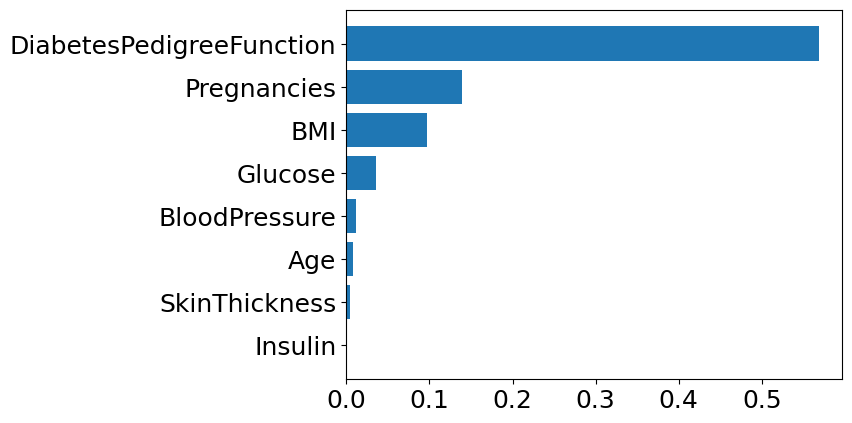

In [30]:
# Визуализируем признаки в порядке их важности

sorted_idx = np.argsort(logreg_coefs)
sorted_cols = X_train.columns[sorted_idx].tolist()
sorted_fi = logreg_coefs[sorted_idx]

plt.barh(sorted_cols, sorted_fi);

In [31]:
# Чтобы установить библиотеку shap, раскомментируйте строку ниже

!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.1 MB/s eta 0:00:00


In [32]:
import shap

In [33]:
# Функция для извлечения важности признаков

def get_model_name_fi(model, fi_type, X_train=None):
    """Получение важности признаков.

    :param model: обученная модель
    :param fi_type: тип определения важности признаков: 'builded' -- встроенный в класс используемой модели или 'shap' -- с помощью shap-значений
    :param X_train: обучающая выборка (необходима при fi_type='shap')
    :return: название модели и важности признаков
    """
    model_name = str(model)[:str(model).find("(")]

    if fi_type == "builded":
        if "xgbclassifier" in model_name.lower() or "randomforest" in model_name.lower():
            fi = model.feature_importances_
        else:
            # AdaBoostClassifier, StackingClassifier и VotingClassifier не имеют встроенной функции определения важности признаков,
            # но т.к. у нас в оснвое лежат деревья, то мы посчитаем средние важности по всем деревьям
            fi = np.concatenate(
                [
                    dt.feature_importances_.reshape((1, -1)) for dt in model.estimators_
                ]
            ).mean(axis=0)
    elif fi_type == "shap":
        explainer = shap.TreeExplainer(model)
        fi = explainer.shap_values(X_train)
    return model_name, fi

In [34]:
# Функция для визуализации важности признаков для разных моделей

def plot_several_models_feature_importances(models, features, fi_type, X_train=None):
    """Визуализирует важности признаков.

    :param models: список обучненных моделей
    :param features: названия признаков
    :param fi_type: тип определения важности признаков: 'builded' -- встроенный в класс используемой модели или 'shap' -- с помощью shap-значений
    :param X_train: обучающая выборка (необходима при fi_type='shap')
    """
    N = len(models)
    plt.figure(figsize=(10 * N, 8 * (N // 2 + 1)))

    for i, model in enumerate(models):
        model_name, fi = get_model_name_fi(model, fi_type, X_train=X_train)

        if fi_type == "builded":
            plt.subplot(2, N // 2 + 1, i + 1)
            sorted_idx = np.argsort(models[0].feature_importances_)[::-1]
            plt.barh(features[sorted_idx], fi[sorted_idx])
            plt.title(model_name);
        elif fi_type == "shap":
            shap.summary_plot(fi, X_train, plot_type="bar")

    if fi_type == "builded":
        plt.subplot(2, N // 2 + 1, i + 2)
        for i, model in enumerate(models):
            model_name, fi = get_model_name_fi(model, fi_type, X_train=X_train)
            plt.barh(features[sorted_idx], fi[sorted_idx], alpha=0.5, label=model_name)
        plt.legend()
        plt.title("All models");

    plt.show()

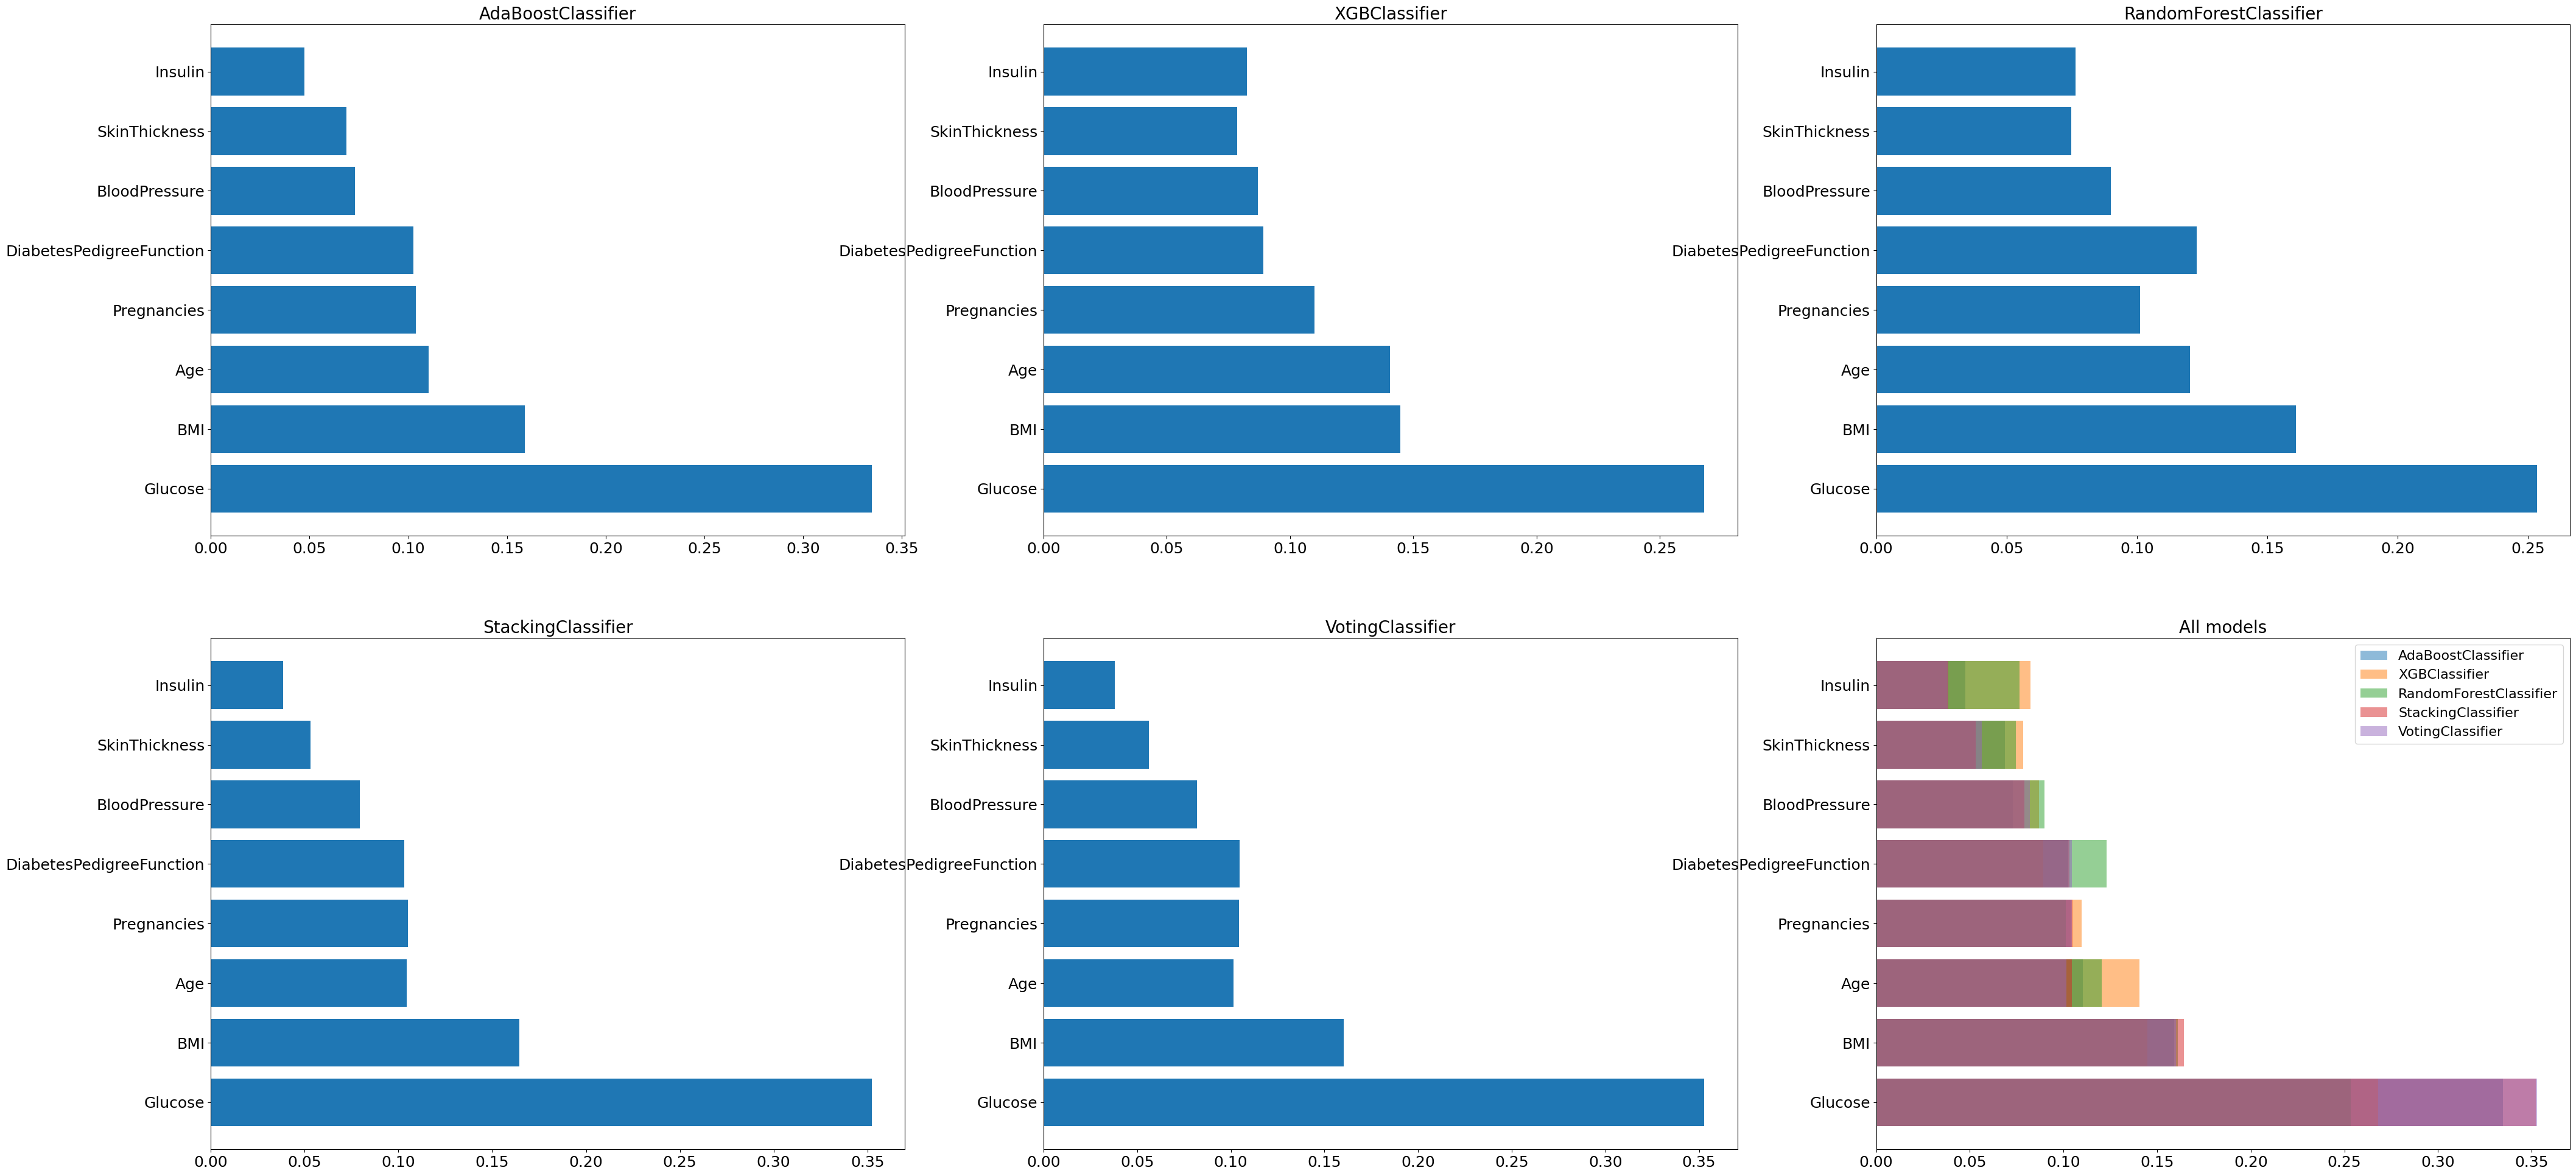

In [35]:
plot_several_models_feature_importances(
    models=[
        model_adab,
        model_xgb,
        model_rf,
        model_trees_stacking,
        model_trees_voting,
    ],
    features=X_train.columns,
    fi_type="builded",
)

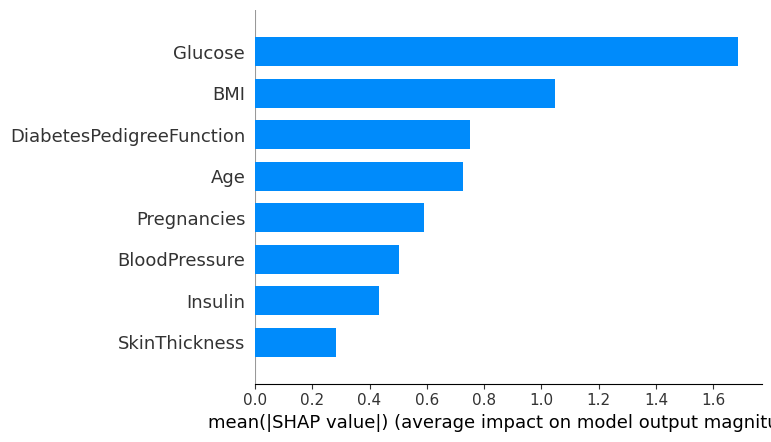

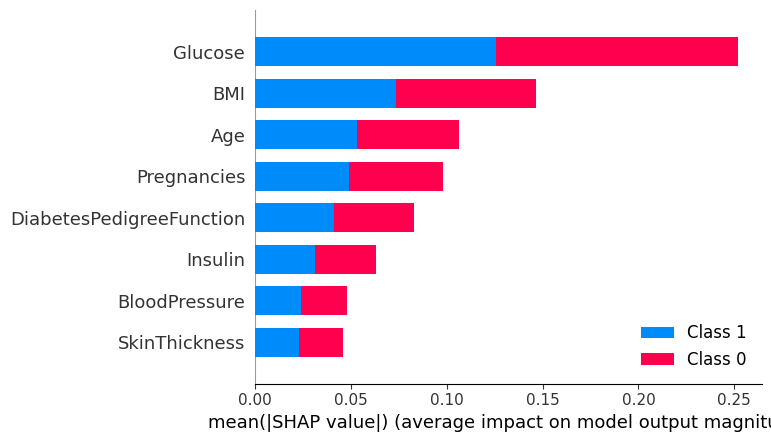

In [36]:
# выявляем самый важный признак среди всех моделей

plot_several_models_feature_importances(
    models=[
        model_xgb,
        model_rf,
        # остальные рассматриваемые нами модели не поддерживаются shap.TreeExplainer, поэтому рассмотрим только эти две модели
    ],
    features=X_train.columns,
    fi_type="shap",
    X_train=X_train,
)

In [37]:
def train_test_n_most_worst_important(n, sorted_idx, columns, model, X_train, y_train, X_test, y_test):
    """Обучение и тестирование модели на n наиболее и наименее важных признаках.

    :param n: количество используемых признаков
    :param sorted_idx: индексы отсортированных по возрастанию важностей признаков
    :param columns: колонки (признаки) исходных данных в исходном порядке
    :param model: модель
    :param X_train: обучающая выборка (без целевой переменной)
    :param y_train: целевая переменная обучающей выборки
    :param X_test: тестовая выборка (без целевой переменной)
    :param y_test: целевая переменная тестовой выборки
    :return: кортеж из следующих кортежей:
             1:
                - n наиболее важных признаков
                - модель, обученная на n наиболее важных признаках
                - предсказания модели (метки классов)
                - предсказания модели (верочтнояти принадлежности к классам)
                - метрики: F1-мера и PR AUC
            2: аналогичный набор, но для n наименее важных признаков
    """
    # наиболее важные признаки
    top_n_features = columns[sorted_idx[:-n-1:-1]].tolist()
    print(
        "{} наиболее важных признаков:\n{}".format(
            n, top_n_features
        )
    )
    model_top_n, pred_top_n, proba_top_n, all_metrics_top_n = model_train_test(
        X_train[top_n_features], y_train,
        X_test[top_n_features], y_test,
        model,
    )
    print("-"*100)
    # наименее важные признаки
    bottom_n_features = columns[sorted_idx[:n]].tolist()
    print(
        "{} наименее важных признаков:\n{}".format(
            n, bottom_n_features
        )
    )
    model_bottom_n, pred_bottom_n, proba_bottom_n, all_metrics_bottom_n = model_train_test(
        X_train[bottom_n_features], y_train,
        X_test[bottom_n_features], y_test,
        model,
    )
    return (
        (
           top_n_features,
           model_top_n,
           pred_top_n,
           proba_top_n,
           all_metrics_top_n
       ), (
            bottom_n_features,
            model_bottom_n,
            pred_bottom_n,
            proba_bottom_n,
            all_metrics_bottom_n
        )
    )

In [38]:
# Создадим словарь из аргументов функции, которые не будут меняться при вызовах
# функции `train_test_n_most_worst_important`

CONFIG = {
    "n": 5,
    "columns": X_train.columns,
    "model": XGBClassifier(),
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

In [39]:
_, fi_xgb = get_model_name_fi(model_xgb, fi_type="builded")
sorted_idx_xgb = np.argsort(fi_xgb)

best_xgb, worst_xgb = train_test_n_most_worst_important(
    sorted_idx=sorted_idx_xgb,
    **CONFIG
)

5 наиболее важных признаков:
['Glucose', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction']
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

F1-мера = 0.565
PR AUC = 0.663
----------------------------------------------------------------------------------------------------
5 наименее 

In [40]:
_, fi_xgb_shap = get_model_name_fi(model_xgb, fi_type="shap", X_train=X_train)

# В `fi_xgb_shap` находится значение важности каждого значения выборки, т.е.
# размер `fi_xgb_shap`: <кол-во элементов в выборке> x <кол-во признаков>.
# Причем если часть значений отрицательные. Поэтому нам необходимо для каждого признака
# посчитать среднее по модулю значение -- это число и будет важностью того или иного признака.

fi_xgb_shap = np.abs(fi_xgb_shap).mean(axis=0)

sorted_idx_xgb_shap = np.argsort(fi_xgb_shap)

best_xgb_shap, worst_xgb_shap = train_test_n_most_worst_important(
    sorted_idx=sorted_idx_xgb_shap,
    **CONFIG
)

5 наиболее важных признаков:
['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies']
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

F1-мера = 0.592
PR AUC = 0.657
----------------------------------------------------------------------------------------------------
5 наименее 

In [41]:
from sklearn.feature_selection import SequentialFeatureSelector

fbs = SequentialFeatureSelector(XGBClassifier(), n_features_to_select=5)
fbs.fit(X_train, y_train)
top_5_features_xgb_fbs = X_train.columns[fbs.support_]

print("5 наиболее важных признаков:\n", top_5_features_xgb_fbs)

best_xgb_fbs = model_train_test(
    X_train[top_5_features_xgb_fbs], y_train,
    X_test[top_5_features_xgb_fbs], y_test,
    XGBClassifier(),
)

5 наиболее важных признаков:
 Index(['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'Age'], dtype='object')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

F1-мера = 0.59
PR AUC = 0.62


In [42]:
# выберем признаки,не попавшие в список наиболее важных

bottom_5_features_xgb_fbs = X_train.columns[~fbs.support_]
# таких признаков будет всего 3 из 8

print("3 наименее важных признака:\n", bottom_5_features_xgb_fbs)

worst_xgb_fbs = model_train_test(
    X_train[bottom_5_features_xgb_fbs], y_train,
    X_test[bottom_5_features_xgb_fbs], y_test,
    XGBClassifier(),
)

3 наименее важных признака:
 Index(['BloodPressure', 'Insulin', 'DiabetesPedigreeFunction'], dtype='object')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

F1-мера = 0.342
PR AUC = 0.379


In [43]:
metrics_df = pd.DataFrame(
    [
        best_xgb[-1], worst_xgb[-1],
        best_xgb_shap[-1], worst_xgb_shap[-1],
        best_xgb_fbs[-1], worst_xgb_fbs[-1]
    ],
    index=[
        "XGBoost top 5 feats", "XGBoost bottom 5 feats",
        "SHAP top 5 feats", "SHAP bottom 5 feats",
        "FBS top 5 feats", "FBS bottom 5 feats"
    ]
)
metrics_df

,F1-score,PR AUC
XGBoost top 5 feats,0.564706,0.662688
XGBoost bottom 5 feats,0.302632,0.394730
SHAP top 5 feats,0.591716,0.657037
SHAP bottom 5 feats,0.392638,0.453148
FBS top 5 feats,0.589595,0.619508
FBS bottom 5 feats,0.341772,0.379296


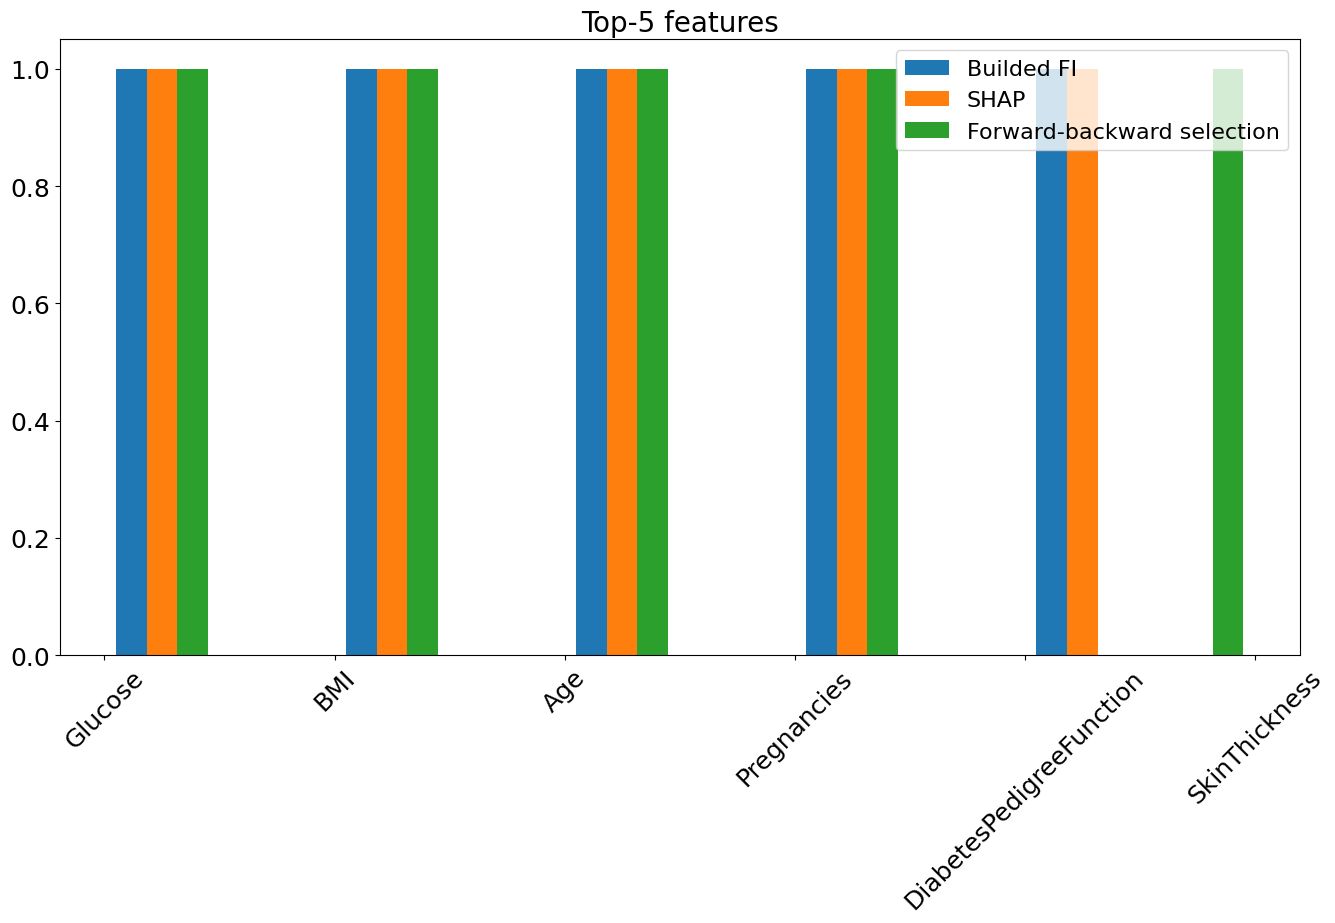

In [44]:
plt.figure(figsize=(16, 8))
plt.title("Top-5 features")
plt.hist(
    [best_xgb[0], best_xgb_shap[0], top_5_features_xgb_fbs],
    label=["Builded FI", "SHAP", "Forward-backward selection"]
)
plt.xticks(rotation=45);
plt.legend();

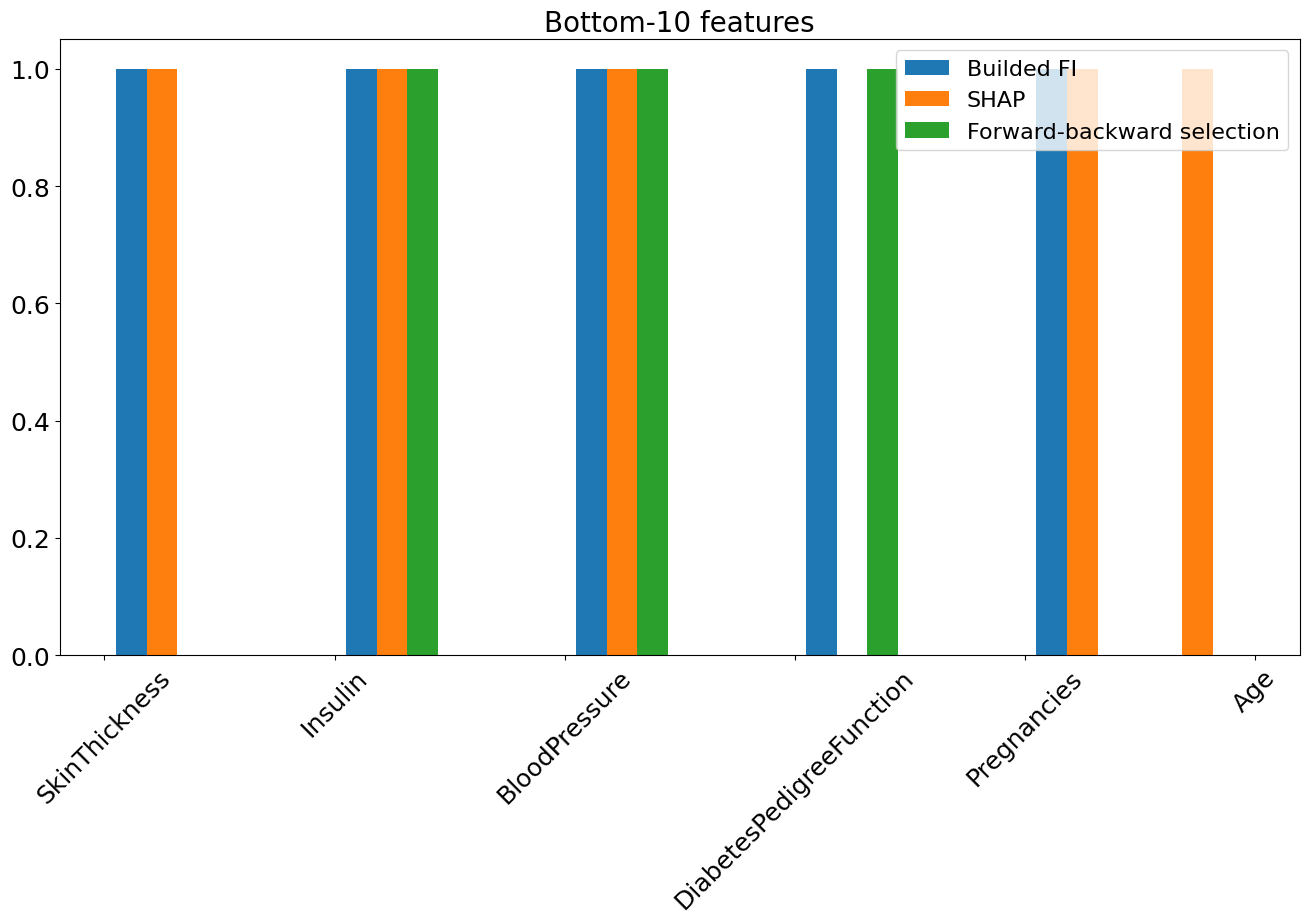

In [45]:
plt.figure(figsize=(16, 8))
plt.title("Bottom-10 features")
plt.hist(
    [worst_xgb[0], worst_xgb_shap[0], bottom_5_features_xgb_fbs],
    label=["Builded FI", "SHAP", "Forward-backward selection"]
)
plt.xticks(rotation=45);
plt.legend();

In [46]:
metrics_df.sort_values(by=["F1-score", "PR AUC"], ascending=False)

,F1-score,PR AUC
SHAP top 5 feats,0.591716,0.657037
FBS top 5 feats,0.589595,0.619508
XGBoost top 5 feats,0.564706,0.662688
SHAP bottom 5 feats,0.392638,0.453148
FBS bottom 5 feats,0.341772,0.379296
XGBoost bottom 5 feats,0.302632,0.394730


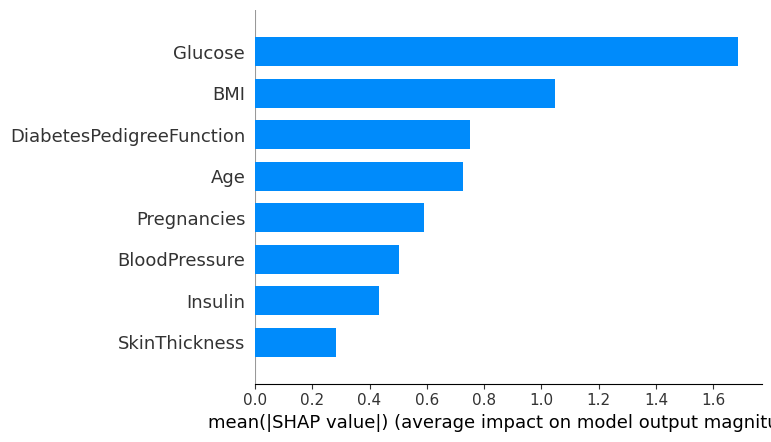

In [47]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar") # ранее использованные гистограммы

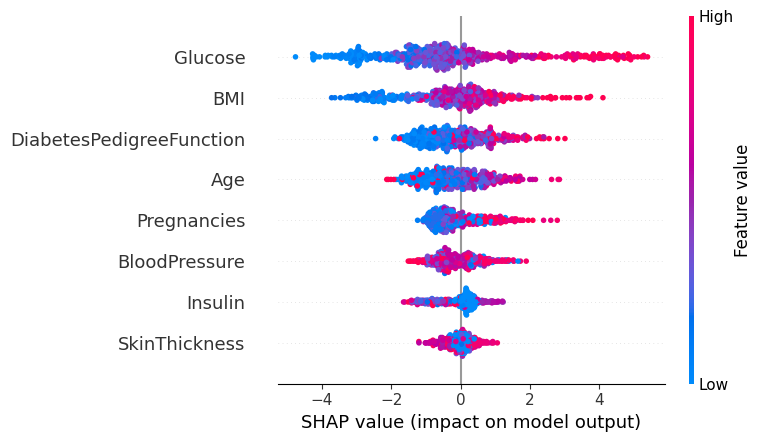

In [48]:
shap.summary_plot(shap_values, X_train)

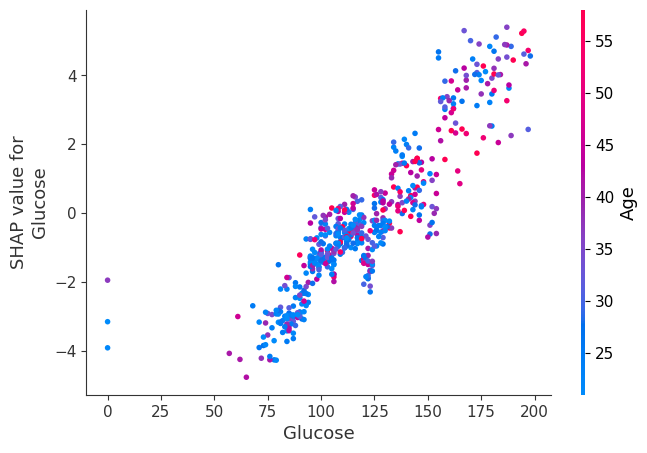

In [49]:
shap.dependence_plot("Glucose", shap_values, X_train, interaction_index="Age")

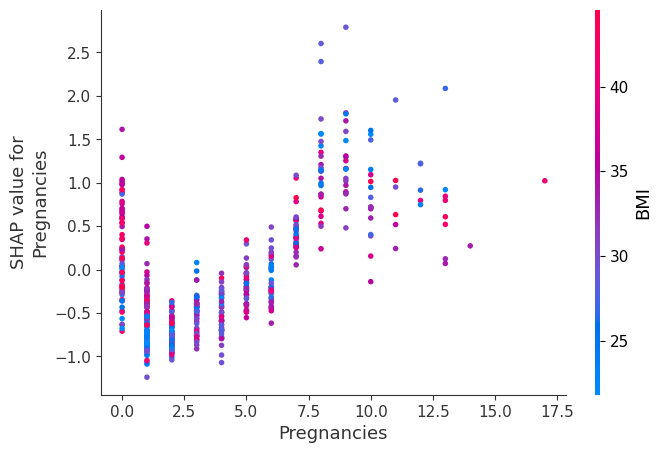

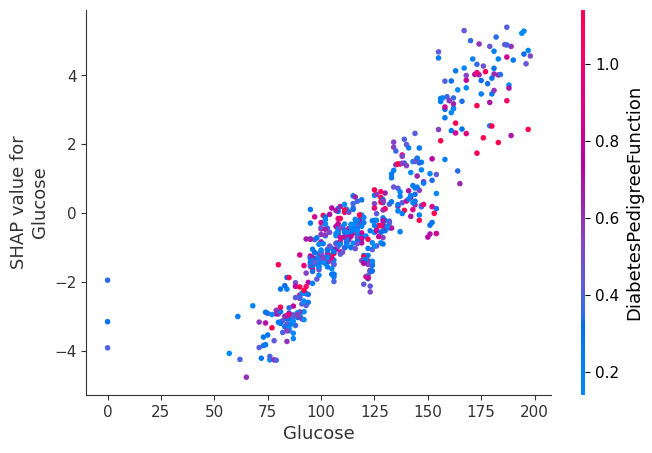

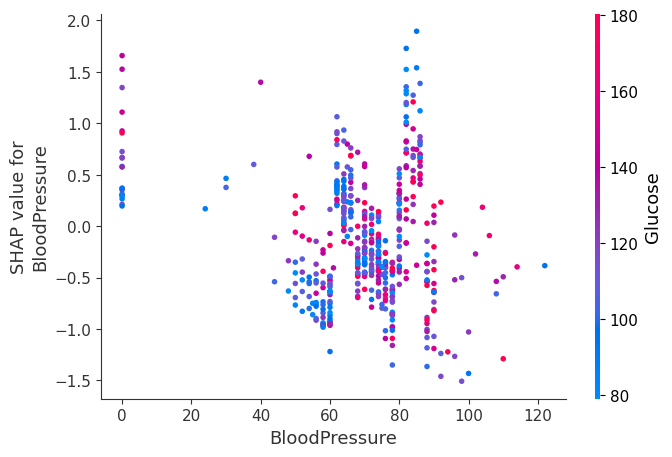

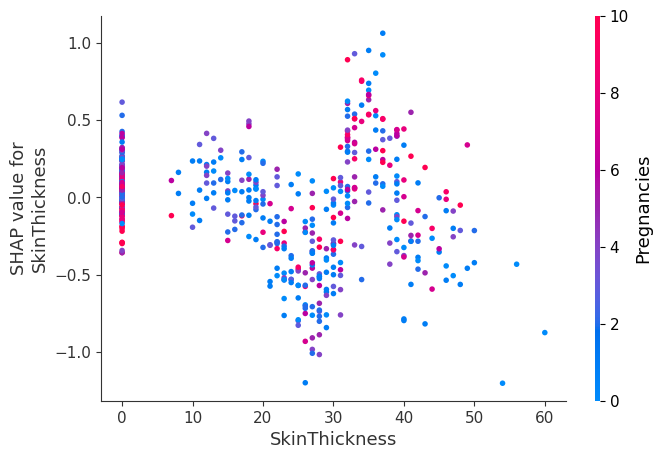

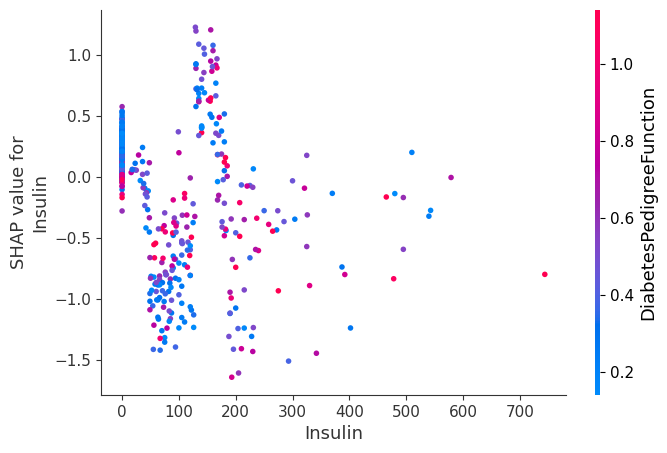

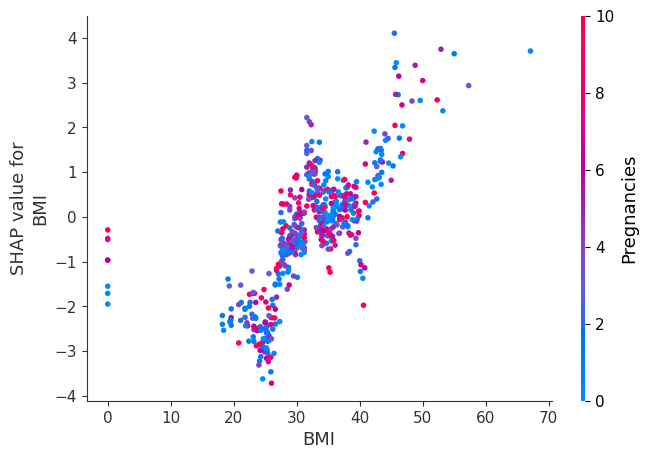

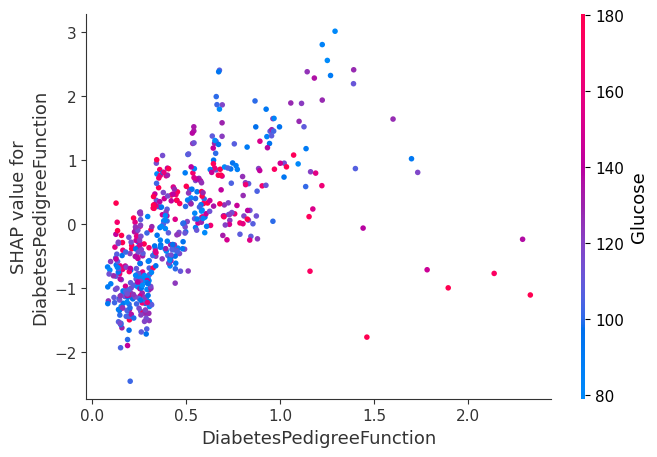

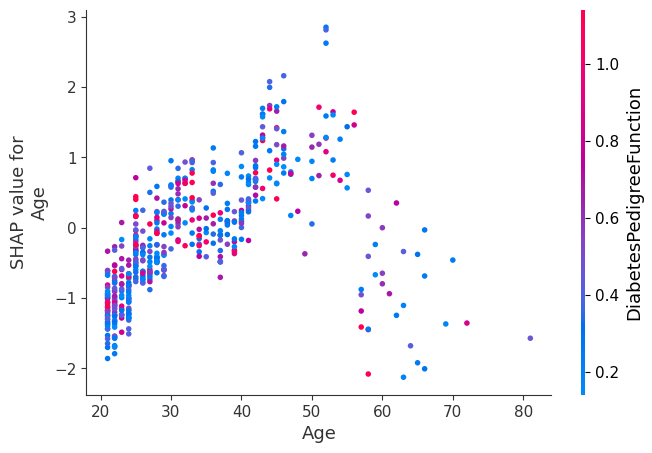

In [50]:
# Графики для всех признаков можно построить следующим образом:

for feature in X_train.columns:
    shap.dependence_plot(feature, shap_values, X_train, display_features=X_train)

In [56]:
# Для каждого наблюдения во всем наборе данных

shap.initjs() # для отображения интерактивного графика
shap.force_plot(explainer.expected_value, shap_values, features=X_train)

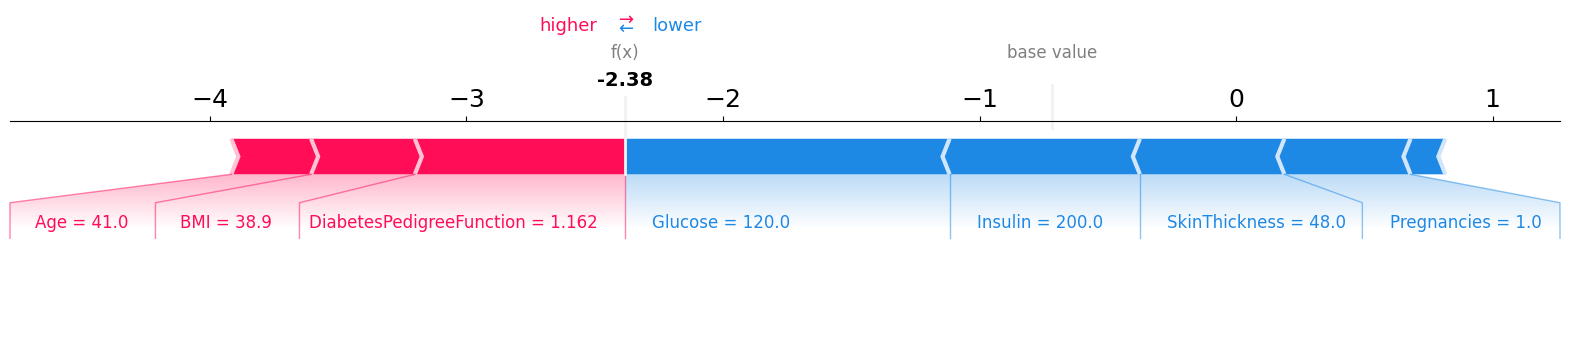

In [59]:
# Для конкретного наблюдения из данных
# (в этой ячейке рассматривается первое наблюдение)

shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0], matplotlib=True)

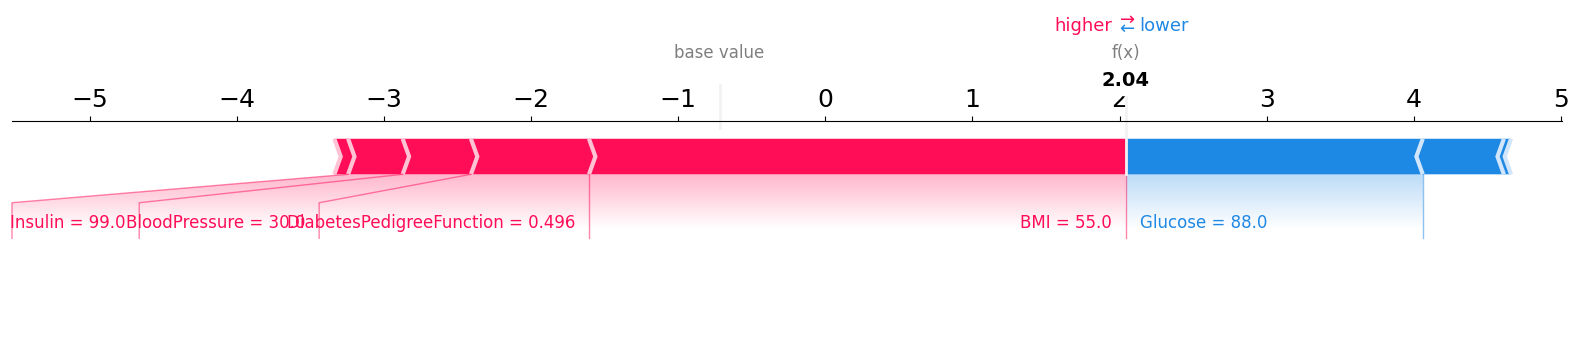

In [61]:
shap.initjs() # для отображения интерактивного графика
shap.force_plot(explainer.expected_value, shap_values[1, :], X_train.iloc[1], matplotlib=True)